This notebook is being developed as part of the Code Kentucky Python Data Analyst pathway.<br>

---

| Field           | Data Type    | Description                                                                                               | Examples                   |
|-----------------|--------------|-----------------------------------------------------------------------------------------------------------|----------------------------|
| District        | Integer      | KYTC divides the state into 12 geographic regions. Districts start from 1 in the West to 12 in the East. | 1, 2, 3, etc.              |
| County          | Object       | The name of the county where the event occurred. County names are proper case.                            | Fayette, Frankfort, etc.  |
| Route           | Object       | The route name associated with the incident.                                                             | KY-80, US-60, I-69        |
| Road_Name       | Object       | The name of the road associated with the transportation records.                                          | DONALDSON CREEK RD, etc. |
| Begin_MP        | Float        | The milepost where the event or condition begins on the road.                                              | 10.5, 20.3, etc.           |
| End_MP          | Float        | The milepost where the event or condition ends on the road.                                                | 15.2, 25.7, etc.           |
| Comments        | Object       | Additional comments or information related to the transportation event.                                   | N/A                        |
| Reported_On     | Datetime     | The date and time when the transportation event was reported. All reports are in Eastern Standard Time.   | YYYY-MM-DD HH:MM:SS       |
| End_Date        | Datetime     | The date and time when the transportation event concluded or was resolved. All reports are in EST.        | YYYY-MM-DD HH:MM:SS       |
| latitude        | Float        | The latitude coordinate associated with the location of the transportation event.                         | 38.1234, 39.5678, etc.    |
| longitude       | Float        | The longitude coordinate associated with the location of the transportation event.                        | -84.5678, -85.1234, etc.  |
| Duration_Default| Timedelta    | The default duration of the transportation event.                                                        | 0 days 01:30:00, etc.     |
| Duration_Hours  | Float        | The duration of the transportation event in hours.                                                        | 1.5, 2.75, etc.            |


Goal: Quantify the impact of road closures based on three metrics:
1) Total number of closures<br>
2) Frequency of closures<br>
3) Duration of closures.<br>

These are a few of the sample questions that I hope to answer:<br>
1) How many closures occur statewide each year? (Normal bar graph showing count per year?)<br>
2) How many road closures occur in each county per year? (Normal bar graph with year as x-axis and count of closures?)<br>
3) How often, or how frequently, is a single road being closed due to rainfall? (Horizonatal bar graph with roadname as Y axis or pivot table output?)<br>
4) What is the average duration of road closures?

Methodology:
1) Import/load road closure data directly from hosted web server into Pandas.<br>
2) Parse out the Latitude and Longitude by stripping unneeded hyperlink characters.<br>
3) Produce standalone latitude and longitude columns/fields, which is preferred for mapping in most BI software.<br>
3) Standardize timestamps to assist with calculating duration.<br>
4) Modify the duration calculation to show hours as float64, making it easier to use in popular BI tools.<br>
5) Summarize the results by year, county, and roadway using record counts and caculated durations.
6) If time allows, develop an overall score that takes into consideration the frequency and duration of events.

DISCLAIMER:  Results may vary.  In addition to historic data, this notebook is also utilizing current year data.  The data source is updated every 1 hour but only when there are active road closures due to weather related events.

-Chris Lambert

---

In [8]:
#Depending on the version, Pandas displays a deprecation notice about pyarrow.
#I have installed the latest pyarrow sepearetly, just in case.
#Import Python Libraries / Dependencies

#Pandas and Matplotlib are the main libraries used in this project.
import pandas as pd
import matplotlib.pyplot as plt #import the matplotlib library for plotting

#The following libraries are used for the web scraping part of the project.
import os
from urllib.request import urlretrieve
#Create the folder if it does not exist
os.makedirs('data-raw', exist_ok=True)
os.makedirs('data-clean', exist_ok=True)
os.makedirs('data-reportready', exist_ok=True)

Alternative method for retrieving data files.

---

In [9]:
#Altenative method of downloading the files.
#If Pandas fails to ingest the CSV into memory and export to the local folder, this will provide an alternative method.
#This allows for discovery of the data with other tools.

#Download the files into the raw-data folder.
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2021.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2021.csv')
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2022.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2022.csv')
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2023.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2023.csv')
#urlretrieve('https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2024.csv', 'data-raw/KYTC-TOC-Weather-Closures-Historic-2024.csv')


2021 Dataset: Specific notes and findings about the dataset are detailed using in-line comments.

---

In [10]:
#Analyze the 2021 dataset.  I prefer to perform the import and cleaning in-memory as opposed to using local files.

#Load the 2021 dataset from the web server. 
df2021=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2021.csv")

#Export the 2021 dataset to a csv file as a method of copying the data to the local machine.
#This gives me a backup of the file and something to reference. 
df2021.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2021.csv", index=False)

#After reviewing the data, I noticed that the 'Route_Link' column contains a URL.
#The url needs to be cleaned to reveal the latitude and longitude, just in case I need them for mapping.
#I assume a strip that essentially performs a find/replace would work here.
df2021['Route_Link'] = df2021['Route_Link'].str.replace('https://kytc.maps.arcgis.com/apps/webappviewer/index.html?id=327a38decc8c4e5cb882dc6cd0f9d45d&zoom=14&center=', '')
df2021[['longitude','latitude']] = df2021.Route_Link.str.split(",",expand=True,)
df2021 = df2021.drop('Route_Link', axis=1)

#After reviewing the data, I noticed the following issues:
#'Reported_On' and 'End_Date' columns contain what looks like different timestamps.
#I checked with the data owners this is a known issue.  They are unable to provide additional guidance.
#I am proceeding, knowing that my duration calculation may be off by 4 hours
#I need to clean that before I can calculate the duration.
#I also noticed that the 'Comments' column contains line breaks.
df2021['End_Date'] = df2021['End_Date'].str.replace('+00:00', '')
df2021['Reported_On'] = pd.to_datetime(df2021['Reported_On'])
df2021['End_Date'] = pd.to_datetime(df2021['End_Date'])
df2021['Duration_Default'] = (df2021['End_Date']) - (df2021['Reported_On'])
df2021['Duration_Hours'] = (df2021['Duration_Default'].dt.total_seconds() / 3600).round(4)
df2021['Comments'] = df2021['Comments'].replace(r'[\r\n]+', ' ', regex=True) #removing line breaks from the comments column.
order=['District','County','Route','Road_Name','Begin_MP','End_MP','Comments','Reported_On','End_Date','latitude','longitude','Duration_Default','Duration_Hours']
df2021.drop_duplicates(inplace=True)
    
#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2021.dtypes) #verify the datatypes in the dataframe
#print(df2021.head(3)) #print the first 3 rows of the dataframe

#Export the clean 2021 dataset to a csv file to show progress.
df2021.to_csv("data-clean/kytc-closures-2021-clean.csv", index=False)


2022 Dataset: Specific notes and findings about the dataset are detailed using in-line comments.

---

In [11]:
#Analyze the 2022 dataset.  I prefer to perform the import and cleaning in-memory as opposed to using local files.

#Load the 2022 dataset from the web server.
df2022=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2022.csv")

#Export the 2022 dataset to a csv file as a method of copying the data to the local machine. 
df2022.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2022.csv", index=False)

#After reviewing the data, I realized that the 'Route_Link' column contains a different URL from the previous dataset.
#The characters in the URL are different and the latitude and longitude are in a different order.
df2022['Route_Link'] = df2022['Route_Link'].str.replace('https://goky.ky.gov/?lat=','')
df2022['Route_Link'] = df2022['Route_Link'].str.replace('&lng=',',')
df2022['Route_Link'] = df2022['Route_Link'].str.replace('&zoom=14','')
df2022[['latitude','longitude']] = df2022.Route_Link.str.split(",",expand=True,) #removing line breaks from the comments column.
df2022 = df2022.drop('Route_Link', axis=1)

#After reviewing the data, I noticed that the 'Reported_On' and 'End_Date' columns seem to be the same timestamp.
#I need to clean that before I can calculate the duration.
#The reported_on time and the end_date are the same timestamps, which is a change from the previous dataset.
#Since it will not cause any harm to the data, I am keeping the str.replace.
#I also noticed that the 'Comments' column contains line breaks.
df2022['End_Date'] = df2022['End_Date'].str.replace('+00:00', '')
df2022['Reported_On'] = pd.to_datetime(df2021['Reported_On'])
df2022['End_Date'] = pd.to_datetime(df2021['End_Date'])
df2022['Duration_Default'] = (df2022['End_Date']) - (df2022['Reported_On'])
df2022['Duration_Hours'] = (df2022['Duration_Default'].dt.total_seconds() / 3600).round(4)
df2022['Comments'] = df2022['Comments'].replace(r'[\r\n]+', ' ', regex=True) #removing line breaks from the comments column.

#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2022.dtypes) #verify the datatypes in the dataframe
#print(df2022.head(3)) #print the first 3 rows of the dataframe

#Export the clean 2022 dataset to a csv file to show progress.
df2022.to_csv("data-clean/kytc-closures-2022-clean.csv", index=False)

df2022.drop_duplicates(inplace=True)


2023 Dataset: Specific notes and findings about the dataset are detailed using in-line comments.

---

In [12]:
#Analyze the 2023 dataset.

#The ending characters were incorrectly published and included the roadname in additon to the zoom level.

#Load the 2022 dataset from the web server. 
df2023=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2023.csv")

#Export the 2022 dataset to a csv file as a method of copying the data to the local machine. 
df2023.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2023.csv", index=False)

#After reviewing the data, I noticed that the 'Route_Link' column contains an error in the URL.
#This will require some additional work to strip the unwanted values.
#The placement of latitude and longitude are consistent between 2022-2024.
#The error occurs at the end of the URL, where someone has inserted a route name.
#This will require a regex to remove all characters after, and including, the &.
df2023['Route_Link'] = df2023['Route_Link'].str.replace('https://goky.ky.gov/?lat=','')
df2023['Route_Link'] = df2023['Route_Link'].str.replace('&lng=',',')
df2023['Route_Link'] = df2023['Route_Link'].str.replace('&.*', '', regex=True) #Regex was needed to compensate for an output error in the 2023 data.
df2023[['latitude','longitude']] = df2023.Route_Link.str.split(",",expand=True,)
df2023 = df2023.drop('Route_Link', axis=1)

#I need to clean that before I can calculate the duration.
#The reported_on time and the end_date are the same from the previous dataset.  No changes are needed.
#I also noticed that the 'Comments' column contains line breaks.
df2023['End_Date'] = df2023['End_Date'].str.replace('+00:00', '')
df2023['Reported_On'] = pd.to_datetime(df2023['Reported_On'])
df2023['End_Date'] = pd.to_datetime(df2023['End_Date'])
df2023['Duration_Default'] = (df2023['End_Date']) - (df2023['Reported_On'])
df2023['Duration_Hours'] = (df2023['Duration_Default'].dt.total_seconds() / 3600).round(4)
df2023['Comments'] = df2023['Comments'].replace(r'[\r\n]+', ' ', regex=True) #removing line breaks from the comments column.

#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2023.dtypes) #verify the datatypes in the dataframe
#print(df2023.head(3)) #print the first 3 rows of the dataframe

#Export the clean 2023 dataset to a csv file to show progress.
df2023.to_csv("data-clean/kytc-closures-2023-clean.csv", index=False)

df2023.drop_duplicates(inplace=True)

2024 Dataset: Specific notes and findings about the dataset are detailed using in-line comments.<br>
2024 is the current year of this analysis so this dataset will update ever hour during weather events.

---

In [13]:
#Analyze the 2024 dataset.
#Since this is 2024, this dataset is updated every 1 hour during weather events.
#This will produce different calculations throughout the year.

#Load the 2024 dataset from the web server. 
df2024=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2024.csv")

#Export the 2024 dataset to a csv file as a method of copying the data to the local machine. 
df2024.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2024.csv", index=False)

#The url needs to be cleaned.
#The placement of latitude and longitude are consistent between 2022-2024 but the ending of the URL in 2023 forced me to use a regex.
df2024['Route_Link'] = df2024['Route_Link'].str.replace('https://goky.ky.gov/?lat=','')
df2024['Route_Link'] = df2024['Route_Link'].str.replace('&lng=',',')
df2024['Route_Link'] = df2024['Route_Link'].str.replace('&.*', '', regex=True)
df2024[['latitude','longitude']] = df2024.Route_Link.str.split(",",expand=True,)
df2024 = df2024.drop('Route_Link', axis=1)

#I need to clean that before I can calculate the duration.
#The reported_on time and the end_date are the same timestamps but I'm keeping the strip code in just in case.
#I also noticed that the 'Comments' column contains line breaks.
df2024['End_Date'] = df2024['End_Date'].str.replace('+00:00', '')
df2024['Reported_On'] = pd.to_datetime(df2024['Reported_On'])
df2024['End_Date'] = pd.to_datetime(df2024['End_Date'])
df2024['Duration_Default'] = (df2024['End_Date']) - (df2024['Reported_On'])
df2024['Duration_Hours'] = (df2024['Duration_Default'].dt.total_seconds() / 3600).round(4)
df2024['Comments'] = df2024['Comments'].replace(r'[\r\n]+', ' ', regex=True) #removing line breaks from the comments column.

#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2024.dtypes) #verify the datatypes in the dataframe
#print(df2024.head(3)) #print the first 3 rows of the dataframe

#Remove any duplicate rows in the dataframe.
df2024.drop_duplicates(inplace=True)

#Export the clean 2023 dataset to a csv file to show progress.
df2024.to_csv("data-clean/kytc-closures-2024-clean.csv", index=False)

In [14]:
#Analyze the 2025 dataset.
#Since this is 2025, this dataset is updated every 1 hour during weather events.
#This will produce different calculations throughout the year.

#Load the 2025 dataset from the web server. 
df2025=pd.read_csv("https://storage.googleapis.com/kytc-its-2020-openrecords/toc/KYTC-TOC-Weather-Closures-Historic-2025.csv")

#Export the 2024 dataset to a csv file as a method of copying the data to the local machine. 
df2025.to_csv("data-raw/KYTC-TOC-Weather-Closures-Historic-2025.csv", index=False)

#The url needs to be cleaned.
#The placement of latitude and longitude are consistent between 2022-2024 but the ending of the URL in 2023 forced me to use a regex.
df2025['Route_Link'] = df2025['Route_Link'].str.replace('https://goky.ky.gov/?lat=','')
df2025['Route_Link'] = df2025['Route_Link'].str.replace('&lng=',',')
df2025['Route_Link'] = df2025['Route_Link'].str.replace('&.*', '', regex=True)
df2025[['latitude','longitude']] = df2025.Route_Link.str.split(",",expand=True,)
df2025 = df2025.drop('Route_Link', axis=1)

#I need to clean that before I can calculate the duration.
#The reported_on time and the end_date are the same timestamps but I'm keeping the strip code in just in case.
#I also noticed that the 'Comments' column contains line breaks.
df2025['End_Date'] = df2025['End_Date'].str.replace('+00:00', '')
df2025['Reported_On'] = pd.to_datetime(df2025['Reported_On'])
df2025['End_Date'] = pd.to_datetime(df2025['End_Date'])
df2025['Duration_Default'] = (df2025['End_Date']) - (df2025['Reported_On'])
df2025['Duration_Hours'] = (df2025['Duration_Default'].dt.total_seconds() / 3600).round(4)
df2025['Comments'] = df2025['Comments'].replace(r'[\r\n]+', ' ', regex=True) #removing line breaks from the comments column.

#Uncomment the lines below to verify datatypes and review data in dataframe.
#print(df2024.dtypes) #verify the datatypes in the dataframe
#print(df2024.head(3)) #print the first 3 rows of the dataframe

#Remove any duplicate rows in the dataframe.
df2025.drop_duplicates(inplace=True)

#Export the clean 2025 dataset to a csv file to show progress.
df2025.to_csv("data-clean/kytc-closures-2025-clean.csv", index=False)

Order and Merge Dataframes<br>
Create Reporting Datasets in Different File Formets<br>
CSV, XLXS, and Parquet are all popular formats among various types of users and use cases.

---

In [15]:
#Merge the following dataframes together.
#In 2021, the columns are in a slightly different order.

#I've developed a column list to force uniformity between the datasets.
col_order=['District','County','Route','Road_Name','Begin_MP','End_MP','Comments','Reported_On','End_Date','latitude','longitude','Duration_Default','Duration_Hours']
df2021=df2021[col_order]
df2022=df2022[col_order]
df2023=df2023[col_order]
df2024=df2024[col_order]
df2025=df2025[col_order]

#One last analysis of the data revealed erroneous time calculations.  I should have caught this earlier.
#There are 6 records that calculate negative duration_hours.  Since these are erroneous, I have removed them.
#While not all data is completely accurate, it is completely possible to see closures lasting 100s of days for repair.
df2021 = df2021[df2021['Duration_Hours'] > 0]
df2022 = df2022[df2022['Duration_Hours'] > 0]
df2023 = df2023[df2023['Duration_Hours'] > 0]
df2024 = df2024[df2024['Duration_Hours'] > 0]
df2025 = df2025[df2025['Duration_Hours'] > 0]

#Merge the dataframes together into a single, cleaned reporting dataset.
df = pd.concat([df2021, df2022, df2023, df2024, df2025])

# Remove duplicates based on latitude, longitude, Reported_On, and Comments
df = df.drop_duplicates(subset=['latitude', 'longitude', 'Reported_On', 'Comments'])

#Export to CSV
#CSV is normally my default export file format since it easy to read and manipulate using simple text editors.
df.to_csv("data-reportready/kytc-closures-2021-2024-report_dataset.csv", index=False) 

#Export to XLSX
#XLSX is useful and prefered over CSV by most MS Office users.
#Requires the openpyxl library to be installed.
df.to_excel("data-reportready/kytc-closures-2021-2024-report_dataset.xlsx", index=False) 

#Parquest is a compressed, columnar storage format, which is good for analytics.
#Parquet is used by many of the modren data platforms.
df.to_parquet("data-reportready/kytc-closures-2021-2024-report_dataset.parquet", index=False)


Develop Visualizations (matplotlib)<br>
First, verify the data types.

---

In [16]:
#df.info() #Print the dataframe info to the console.  This is useful for debugging and understanding the data.

This first section will deal with counting the number of closures per Year, District, and then County

---

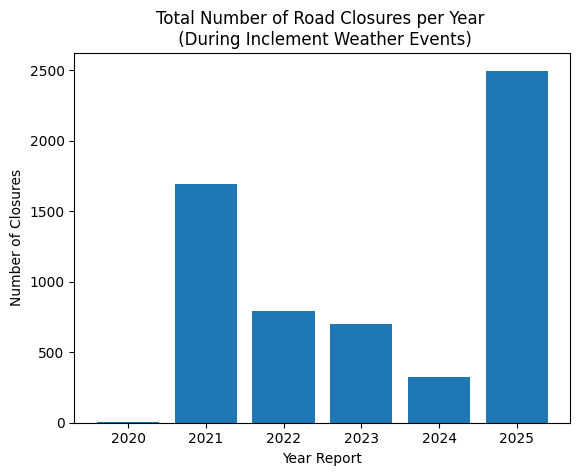

In [17]:
#Extract the year from "Reported_On" value to use on the plot.
df['Year'] = df['Reported_On'].dt.year

#Count the number of closures per year
closure_counts = df['Year'].value_counts()

# Plot the data
plt.bar(closure_counts.index, closure_counts.values)
plt.xlabel('Year Report')
plt.ylabel('Number of Closures')
plt.title('Total Number of Road Closures per Year \n (During Inclement Weather Events)') #ading the \n forces a line break in the title.
plt.show()


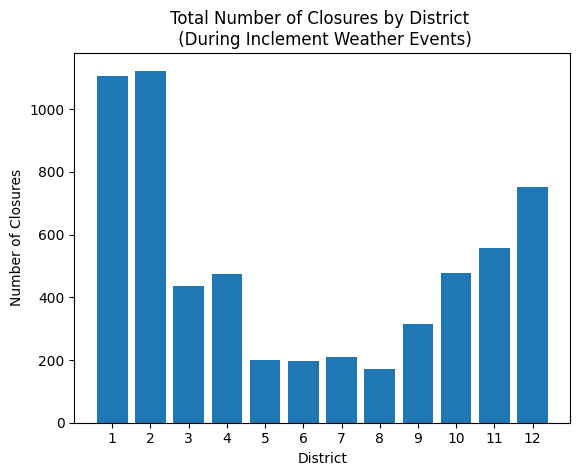

In [18]:
#Calculate the number of closures per district and then plot the data.
closure_counts_by_district = df['District'].value_counts()

# Plot the data
plt.bar(closure_counts_by_district.index, closure_counts_by_district.values)
plt.xlabel('District')
plt.ylabel('Number of Closures')
plt.title('Total Number of Closures by District \n (During Inclement Weather Events)')

# Set the x-axis ticks to show all 12 districts
plt.xticks(closure_counts_by_district.index)

plt.show()


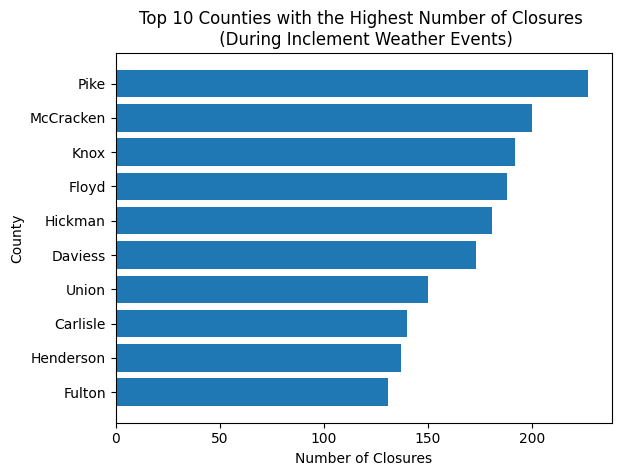

In [19]:
# Calculate the number of closures per County
closure_counts_by_county = df['County'].value_counts()

# Select the top 10 counties
top_10_counties = closure_counts_by_county.head(10) #adjust for more counties if needed.

# Sort the counties by the number of closures in descending order
top_10_counties = top_10_counties.sort_values(ascending=True)

# Plot the data
plt.barh(top_10_counties.index, top_10_counties.values)
plt.xlabel('Number of Closures')
plt.ylabel('County')
plt.title('Top 10 Counties with the Highest Number of Closures \n (During Inclement Weather Events)')

plt.show()


This section will deal with summarizing the duration of closures per year, district, and county.

---

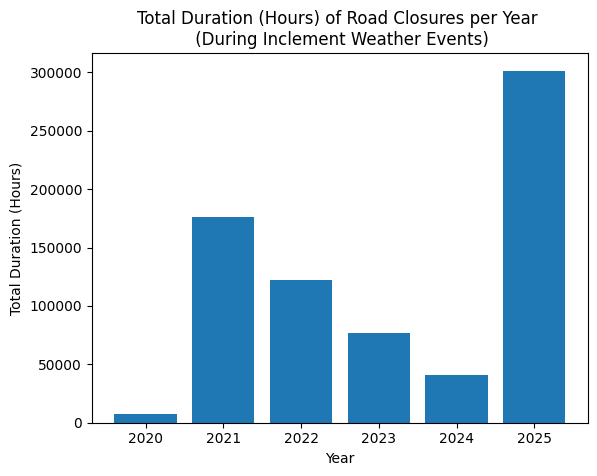

In [20]:
# Total the duration_hours per year
total_duration = df.groupby(df['Reported_On'].dt.year)['Duration_Hours'].sum()

plt.bar(total_duration.index, total_duration.values)

plt.xlabel('Year')
plt.ylabel('Total Duration (Hours)')
plt.title('Total Duration (Hours) of Road Closures per Year \n (During Inclement Weather Events)')
plt.show()



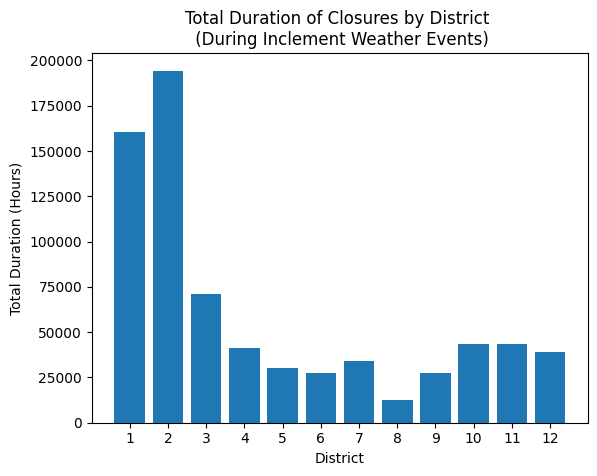

In [21]:
# Calculate the total hours of closures by District and plot the data.
total_duration_by_district = df.groupby('District')['Duration_Hours'].sum()

# Plot the data
plt.bar(total_duration_by_district.index, total_duration_by_district.values)
plt.xlabel('District')
plt.ylabel('Total Duration (Hours)')
plt.title('Total Duration of Closures by District \n (During Inclement Weather Events)')

# Set the x-axis ticks to show all 12 districts
plt.xticks(total_duration_by_district.index)

plt.show()



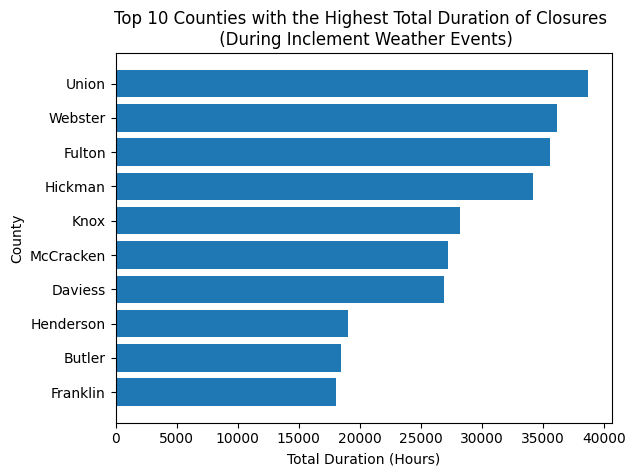

In [22]:
# Calculate the total hours of closures by County
total_duration_by_county = df.groupby('County')['Duration_Hours'].sum()

# Select the top 10 counties
top_10_counties = total_duration_by_county.nlargest(10) #adjust for more counties if needed.

# Sort the counties by the total duration in descending order
top_10_counties = top_10_counties.sort_values(ascending=True)

# Plot the data
plt.barh(top_10_counties.index, top_10_counties.values)
plt.xlabel('Total Duration (Hours)')
plt.ylabel('County')
plt.title('Top 10 Counties with the Highest Total Duration of Closures \n (During Inclement Weather Events)')

plt.show()


Optional Feature: Check for PowerBI file and PDF export in the repo.

---